In [1]:
data_path = '/home/tli_project/Desktop/Data/T4/neurons/'
save_path = '/home/tli_project/Desktop/Data/T4/neurons/output/'

##
# start_age = 36.5
stab_limit = 4 #(No. of timepoints for stable branches calculation)
nor_fact = 1 #this is for normalizing Col_occpancy. for now there is no other option, like neuron max

if save_path[-1] != '/':
    save_path += '/'

In [2]:
import os
import utils.analysis as analysis
import utils.datautils as datautils
import matplotlib.pyplot as plt
import tifffile as tif
import numpy as np
import re

In [3]:
files_list = datautils.get_file_names(data_path, group_by='', 
                                        order=True, nested_files=False, 
                                        criteria='tif')

first 5 files
['/home/tli_project/Desktop/Data/T4/neurons/seg_1_211107_P36_N1_GFP.tif', '/home/tli_project/Desktop/Data/T4/neurons/seg_1_211104_P36_N1_GFP.tif', '/home/tli_project/Desktop/Data/T4/neurons/seg2_211113_P36_N2_GFP.tif', '/home/tli_project/Desktop/Data/T4/neurons/seg2_211113_P36_N1_GFP.tif']


calculating tansient: 100%|██████████| 86/86 [00:00<00:00, 135.42it/s]


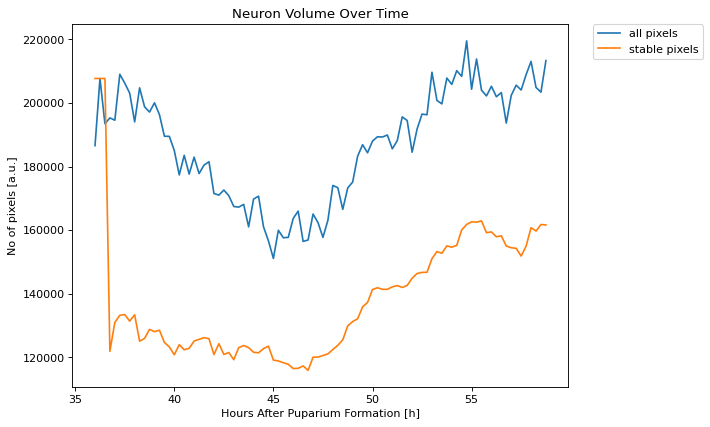

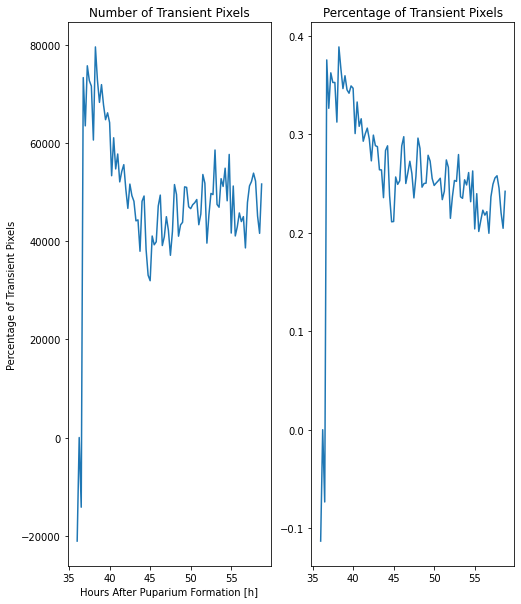

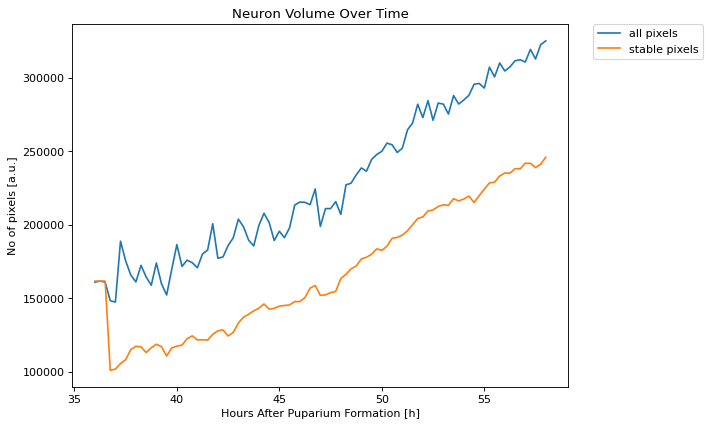

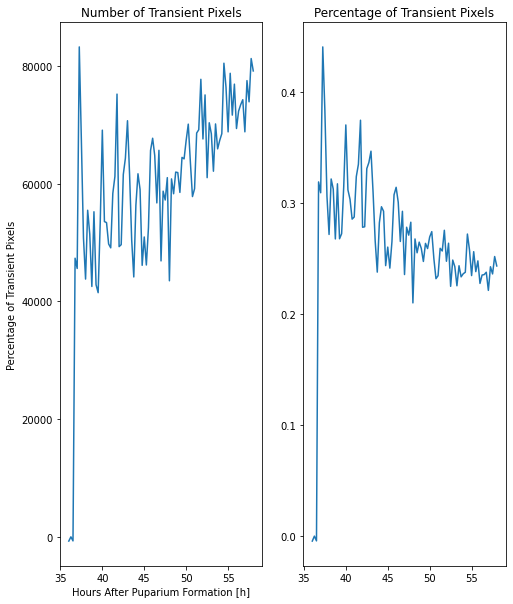

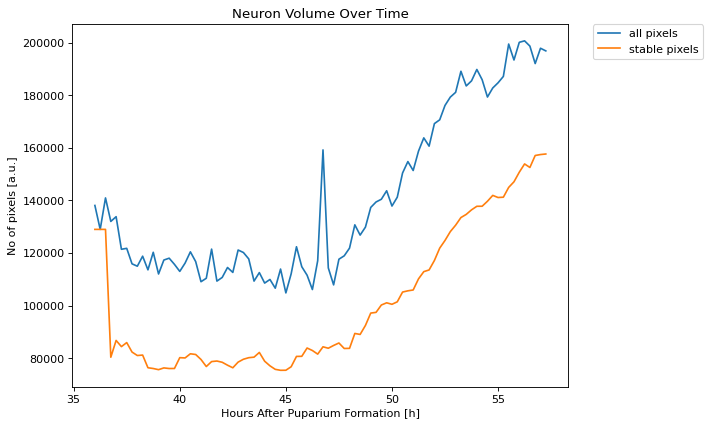

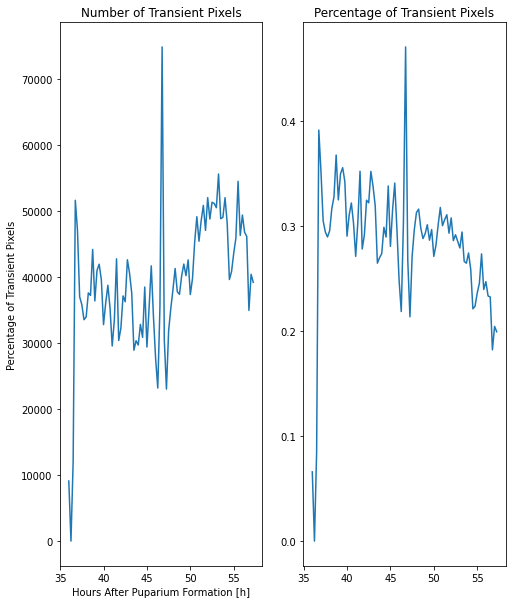

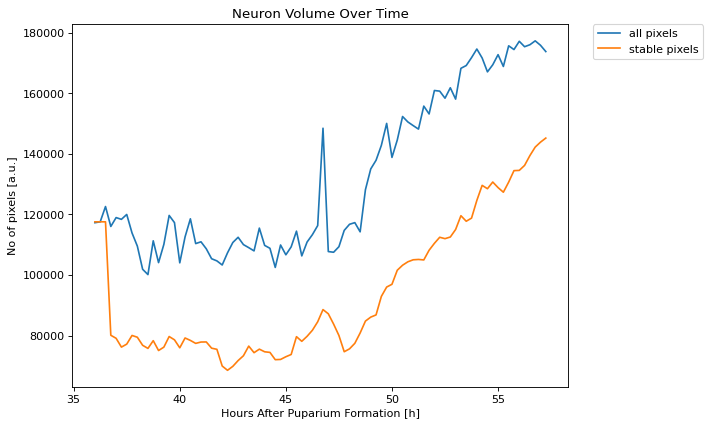

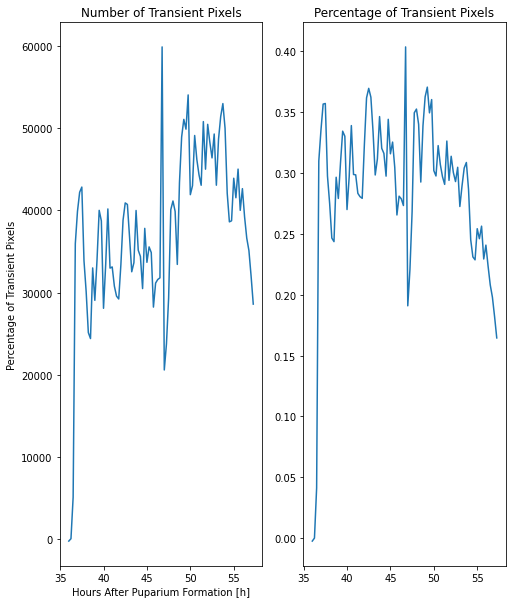

In [4]:
for file in files_list:
    file_name = os.path.basename(file)
    start_age = re.search('P(.*)_N', file_name)
    start_age = float(start_age.group(1))
    neuron = tif.imread(file)
    neuron[neuron != 0] = 1
    stable_n = analysis.stable_branch(neuron, stab_limit=stab_limit, save=True, 
                                        save_path=save_path, save_file=file_name, 
                                        xy_pixel=0.076, z_pixel=0.4)
    analysis.N_volume(neuron, stable_n, normalize=False, 
                    start_t=start_age, plot=True, 
                    save=True, save_path=save_path, 
                    save_file='Vol_'+file_name)
    analysis.trans_px(neuron, stable_n, 
                        start_t=36, plot=True, 
                        save=True, save_path=save_path, 
                        save_file='transient_'+file_name)
    del neuron, stable_n